# Random Forest - Week 07 - Micro Credit

Last week we introduced decision trees, which we used to predict credit approvals. This week we will extend the basic decision trees by two powerful ideas.  
First we will have a look at __Bagging__ and then at __Random Forests__. Afterwards __Hyperparameter Tuning__ will be demonstrated and last but not least we will examine __Permutation based feature importance__ as an interpretability approach.

In [1]:
# Imports
import numpy as np
import random
# Set seed for reproducibility
np.random.seed(42)  # Set seed for NumPy
random.seed(42) # Set seed for random module

## Load Data

In [2]:
import pandas as pd
# Load the data
data = pd.read_csv("https://raw.githubusercontent.com/kbrennig/MODS_WS24_25/refs/heads/main/data/MicroCredit.csv")

## Explore data

First let's have a look at the raw data.

*Run the code below.*

In [3]:
data.head()

,ID,Decision,Build_Selfcon,Tier,Accommodation_Class,Loan_Type,Gender,Employment_Type,Doc_Proof_Inc,Marital_Status,...,LoanReq,Term,Dwnpay,BankSave,CalcEmi,IIR,IAR,FOIR,LTV,LVR
0,FBD-E2B0-588300,1,Self Contruction,2,Non_Rented,Home_Loan,Female,Salaried,N,Married,...,780000,180,670000,0,12004.230470,34.999797,45.000114,34.999797,80.000000,54.000000
1,GUJ-A79X-831476,0,Self Contruction,1,Non_Rented,Home_Loan,Female,Self_Employed,N,Married,...,800000,180,470000,0,12312.030270,49.248121,75.533928,49.248121,62.992126,62.992126
2,SHB-947O-759226,1,Self Contruction,3,Rented,Home_Loan,Female,Salaried,N,Married,...,480000,120,120000,300000,8342.290039,41.999144,79.998946,41.999144,78.999992,80.000000
3,SHB-7S3I-679761,1,Self Contruction,3,Non_Rented,Home_Loan,Female,Self_Employed,N,Married,...,300000,180,95000,0,4617.009766,30.999126,84.996498,30.999126,20.000000,76.000000
4,VAD-BPKZ-551476,0,Self Contruction,2,Non_Rented,Home_Loan,Female,Self_Employed,N,Married,...,1000000,180,375000,0,15390.040040,45.000117,57.999020,45.000117,73.000001,73.000000


In [4]:
print(data.describe())
data.dtypes

          Decision         Tier       eom_25     OldEmi_d   BankSave_d  \
count  1256.000000  1256.000000  1256.000000  1256.000000  1256.000000   
mean      0.799363     1.980096     0.216561     0.132962     0.118631   
std       0.400636     0.793651     0.412065     0.339669     0.323482   
min       0.000000     1.000000     0.000000     0.000000     0.000000   
25%       1.000000     1.000000     0.000000     0.000000     0.000000   
50%       1.000000     2.000000     0.000000     0.000000     0.000000   
75%       1.000000     3.000000     0.000000     0.000000     0.000000   
max       1.000000     3.000000     1.000000     1.000000     1.000000   

               Age       YrsAdd       YrsJob         Expen         TotInc  \
count  1256.000000  1256.000000  1256.000000   1256.000000    1256.000000   
mean     37.726115     9.933917    10.883758  11946.937102   29911.050955   
std       8.458466    10.575304     7.974213   7390.216194   18748.496342   
min      22.000000     0.

,0
ID,object
Decision,int64
Build_Selfcon,object
Tier,int64
Accommodation_Class,object
Loan_Type,object
Gender,object
Employment_Type,object
Doc_Proof_Inc,object
Marital_Status,object


## Transform data


### Transform variables

Similarly to last week, we drop the ID column.

*Run the code below.*

In [5]:
data_transformed = data.drop(columns="ID")

### Create training and test sets

Business as usual: We create a 80-20 training and test set.

*Run the code below.*

In [6]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data_transformed, test_size=0.2, random_state=42)

### Preprocess Categorical Columns

DecisionTreeClassifier, like many other machine learning models, requires __numerical input data__. If a dataset contains categorical variables or non-numeric data, they need to be __preprocessed before fitting the model__. Therefore categorical variables can be converted into numerical representations using techniques such as __one-hot encoding__. One-hot encoding creates binary columns for each category.

*Run the code below.*

In [7]:
from sklearn.preprocessing import OneHotEncoder
# Dummy encoding / One-hot encoding

categorical_columns = [
    "Tier",
    "Build_Selfcon",
    "Accommodation_Class",
    "Loan_Type",
    "Gender",
    "Employment_Type",
    "Doc_Proof_Inc",
    "Marital_Status",
    "Employer_Type",
    "Education_Class",
    "Mode_of_origin_class"
]

# Creating the OneHotEncoder object
encoder = OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist', sparse_output=False)

# Fit and transform the training data
encoded_training = encoder.fit_transform(data_train.loc[:,categorical_columns])
# Create a DataFrame with the encoded variables
encoded_training_df = pd.DataFrame(encoded_training, columns=encoder.get_feature_names_out(categorical_columns))
# Join the encoded variables to the original DataFrame and remove the original columns
data_train = data_train.reset_index(drop=True).join(encoded_training_df).drop(columns=categorical_columns)
X_train = data_train.drop(columns="Decision")
y_train = data_train["Decision"]


# Transform the test data
encoded_test = encoder.transform(data_test.loc[:,categorical_columns])
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_columns))
data_test = data_test.reset_index(drop=True).join(encoded_test_df).drop(columns=categorical_columns)
X_test = data_test.drop(columns="Decision")
y_test = data_test["Decision"]

## Bagged Trees by Hand

Bagging (Bootstrap Aggregation) is a statistical method to __reduce variance__ and make predictions more stable. It describes the process of creating multiple __bootstrap samples__ from your training set and using them to train multiple models which are then aggregated to make predictions.  
More specifically the steps for Training are:

1. create m bootstrap samples by sampling from the training set.
2. train m classifiers on the created samples.

When we want to use the model to make predictions on new data, we proceed as follows:

1. make m separate predictions on the new data.
2. aggregate the m predictions by carrying out a __majory vote__. Majority voting outputs the class which occurs most often in the m predictions.

![bagging.png](https://raw.githubusercontent.com/kbrennig/MODS_WS24_25/refs/heads/main/Week_7_exercise/images/bagging.png)
<br>
Source: Raschka (2019)

### Draw 10 boostrap samples (sample with replacement)

First we draw ten samples, using sampling with replacement. Each sample contains as many instances as the original training set (this doesn't mean that all the samples are the same, if unclear think again about sampling with replacement).

*Run the code below.*

In [ ]:
# Get number of observations
n_samples = data_train.shape[0]

# Create 10 bootstrap samples
bootsamp_01 = data_train.sample(replace=True, n=n_samples)
bootsamp_01_X = bootsamp_01.drop(columns="Decision")
bootsamp_01_y = bootsamp_01["Decision"]
bootsamp_02 = data_train.sample(replace=True, n=n_samples)
bootsamp_02_X = bootsamp_02.drop(columns="Decision")
bootsamp_02_y = bootsamp_02["Decision"]
bootsamp_03 = data_train.sample(replace=True, n=n_samples)
bootsamp_03_X = bootsamp_03.drop(columns="Decision")
bootsamp_03_y = bootsamp_03["Decision"]
bootsamp_04 = data_train.sample(replace=True, n=n_samples)
bootsamp_04_X = bootsamp_04.drop(columns="Decision")
bootsamp_04_y = bootsamp_04["Decision"]
bootsamp_05 = data_train.sample(replace=True, n=n_samples)
bootsamp_05_X = bootsamp_05.drop(columns="Decision")
bootsamp_05_y = bootsamp_05["Decision"]
bootsamp_06 = data_train.sample(replace=True, n=n_samples)
bootsamp_06_X = bootsamp_06.drop(columns="Decision")
bootsamp_06_y = bootsamp_06["Decision"]
bootsamp_07 = data_train.sample(replace=True, n=n_samples)
bootsamp_07_X = bootsamp_07.drop(columns="Decision")
bootsamp_07_y = bootsamp_07["Decision"]
bootsamp_08 = data_train.sample(replace=True, n=n_samples)
bootsamp_08_X = bootsamp_08.drop(columns="Decision")
bootsamp_08_y = bootsamp_08["Decision"]
bootsamp_09 = data_train.sample(replace=True, n=n_samples)
bootsamp_09_X = bootsamp_09.drop(columns="Decision")
bootsamp_09_y = bootsamp_09["Decision"]
bootsamp_10 = data_train.sample(replace=True, n=n_samples)
bootsamp_10_X = bootsamp_10.drop(columns="Decision")
bootsamp_10_y = bootsamp_10["Decision"]

### Grow 10 classification trees, each on a different bootstrap sample

Then we train a decision trees on each sample, resulting in ten models.

*Run the code below.*

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model_01 = DecisionTreeClassifier(random_state=42).fit(bootsamp_01_X, bootsamp_01_y)
model_02 = DecisionTreeClassifier(random_state=42).fit(bootsamp_02_X, bootsamp_02_y)
model_03 = DecisionTreeClassifier(random_state=42).fit(bootsamp_03_X, bootsamp_03_y)
model_04 = DecisionTreeClassifier(random_state=42).fit(bootsamp_04_X, bootsamp_04_y)
model_05 = DecisionTreeClassifier(random_state=42).fit(bootsamp_05_X, bootsamp_05_y)
model_06 = DecisionTreeClassifier(random_state=42).fit(bootsamp_06_X, bootsamp_06_y)
model_07 = DecisionTreeClassifier(random_state=42).fit(bootsamp_07_X, bootsamp_07_y)
model_08 = DecisionTreeClassifier(random_state=42).fit(bootsamp_08_X, bootsamp_08_y)
model_09 = DecisionTreeClassifier(random_state=42).fit(bootsamp_09_X, bootsamp_09_y)
model_10 = DecisionTreeClassifier(random_state=42).fit(bootsamp_10_X, bootsamp_10_y)

### Plot individual trees

We can look at the resulting trees by plotting them.

*Run the code below.*

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

models = [model_01, model_02, model_03, model_04, model_05, model_06, model_07, model_08, model_09, model_10]
plot_size = (60, 30)  #define size of plot
for model in models:
    # Create a new figure
    fig, ax = plt.subplots(figsize=plot_size)
    # Plot the tree
    plot_tree(model, ax=ax, feature_names=data_train.drop(columns="Decision").columns, impurity=False, filled=True, rounded=True, proportion=True, class_names=True, fontsize=10)

### Make and aggregate individual predictions

After we trained our models, we use them to make individual predictions on the test data.

*Run the code below.*

In [ ]:
predictions_test_01 = model_01.predict_proba(X_test)
predictions_test_01_binary = np.where(predictions_test_01[:, 1] > 0.5, 1, 0)
predictions_test_02 = model_02.predict_proba(X_test)
predictions_test_02_binary = np.where(predictions_test_02[:, 1] > 0.5, 1, 0)
predictions_test_03 = model_03.predict_proba(X_test)
predictions_test_03_binary = np.where(predictions_test_03[:, 1] > 0.5, 1, 0)
predictions_test_04 = model_04.predict_proba(X_test)
predictions_test_04_binary = np.where(predictions_test_04[:, 1] > 0.5, 1, 0)
predictions_test_05 = model_05.predict_proba(X_test)
predictions_test_05_binary = np.where(predictions_test_05[:, 1] > 0.5, 1, 0)
predictions_test_06 = model_06.predict_proba(X_test)
predictions_test_06_binary = np.where(predictions_test_06[:, 1] > 0.5, 1, 0)
predictions_test_07 = model_07.predict_proba(X_test)
predictions_test_07_binary = np.where(predictions_test_07[:, 1] > 0.5, 1, 0)
predictions_test_08 = model_08.predict_proba(X_test)
predictions_test_08_binary = np.where(predictions_test_08[:, 1] > 0.5, 1, 0)
predictions_test_09 = model_09.predict_proba(X_test)
predictions_test_09_binary = np.where(predictions_test_09[:, 1] > 0.5, 1, 0)
predictions_test_10 = model_10.predict_proba(X_test)
predictions_test_10_binary = np.where(predictions_test_10[:, 1] > 0.5, 1, 0)

# Aggregate the predictions
predictions_test_agg = (predictions_test_01[:, 1] + predictions_test_02[:, 1] + predictions_test_03[:, 1] + predictions_test_04[:, 1] + predictions_test_05[:, 1] + predictions_test_06[:, 1] + predictions_test_07[:, 1] + predictions_test_08[:, 1] + predictions_test_09[:, 1] + predictions_test_10[:, 1]) / 10
predictions_test_agg_binary = np.where(predictions_test_agg > 0.5, 1, 0)

data_test_w_preds = X_test.copy()
data_test_w_preds['predictions_test_agg_binary'] = predictions_test_agg_binary
data_test_w_preds['predictions_test_01_binary'] = predictions_test_01_binary
data_test_w_preds['predictions_test_02_binary'] = predictions_test_02_binary
data_test_w_preds['predictions_test_03_binary'] = predictions_test_03_binary
data_test_w_preds['predictions_test_04_binary'] = predictions_test_04_binary
data_test_w_preds['predictions_test_05_binary'] = predictions_test_05_binary
data_test_w_preds['predictions_test_06_binary'] = predictions_test_06_binary
data_test_w_preds['predictions_test_07_binary'] = predictions_test_07_binary
data_test_w_preds['predictions_test_08_binary'] = predictions_test_08_binary
data_test_w_preds['predictions_test_09_binary'] = predictions_test_09_binary
data_test_w_preds['predictions_test_10_binary'] = predictions_test_10_binary

### Calculate mean accuracy of the 10 individual models on test set

Lastly, we calculate two different accuracies. First we calculate the __mean accuracy over all models__.

*Run the code below.*

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_mean = np.mean([accuracy_score(y_test, predictions_test_01_binary),
                         accuracy_score(y_test, predictions_test_02_binary),
                         accuracy_score(y_test, predictions_test_03_binary),
                         accuracy_score(y_test, predictions_test_04_binary),
                         accuracy_score(y_test, predictions_test_05_binary),
                         accuracy_score(y_test, predictions_test_06_binary),
                         accuracy_score(y_test, predictions_test_07_binary),
                         accuracy_score(y_test, predictions_test_08_binary),
                         accuracy_score(y_test, predictions_test_09_binary),
                         accuracy_score(y_test, predictions_test_10_binary)])

print("Mean accuracy over all models: ", accuracy_mean)

### Calculate accuracy of the bagged trees on test set

And secondly we calculate the __accuracy of the aggregated (averaged) predictions on the test set__.

*Run the code below.*

In [ ]:
accuracy_agg = accuracy_score(y_test, predictions_test_agg_binary)

print("Accuracy of the aggregated (averaged) predictions:", accuracy_agg)

We clearly see the difference in accuracy and validate our assumptions that bagging leads to more stable and more accurate models.

## Random Forest

If we go back to the bagged trees, that we just created and look closely we will see that even though they were trained on different sets there are a lot of similarities between the trees. This is due to the fact, that there are a few very strong independent variables in our dataset that are chosen for most of the upper splits. Since our goal is to create as diverse models as possible this isn't a desired behavior.  

Here __Random Forests__ come into play. Additionally to __Bagging__ they also __restrict the number of predictors__ that can be considered for each split in a tree. This is achieved by __randomly selecting a subset__ of all predictors __for each split__.

### Grow random forest on training data

*Run the code below.*

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Random Forests
rf_01 = RandomForestClassifier(n_estimators=500, random_state=42).fit(X_train, y_train)

### Show results

We can see that there are different parameters that have to be specified in order to train a random forest. The __Number of trees__ (n_estimators) for example tells us how many trees have been trained.   
For a complete list of the `RandomForestClassifier` functions parameters, you can have a look at its [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

*Run the code below.*

In [ ]:
print("Parameters:", rf_01.get_params())

### Make predictions and calculate evaluation metrics on test set

Similarly to last week, we can make predictions on the test set and calculate different evaluation metrics.

*Run the code below.*

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

predictions_testset_rf01 = rf_01.predict_proba(X_test)[:, 1]
predictions_testset_rf01_binary = np.where(predictions_testset_rf01 > 0.5, 1, 0)

# Calculate Accuracy
accuracy_rf = accuracy_score(y_test, predictions_testset_rf01_binary)
print("Accuracy (Random Forests):", accuracy_rf)

# Create the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, predictions_testset_rf01_binary)

### ROC and Auc

Plot ROC curve and calculate AUC on test set.
With __binary__ classification we get relatively straight lines. With the classification __probability__ we can map the distribution better. That is why we use the classification probability (e.g., predictions_testset_rf01) to calculate the AUC.

*Run the code below.*

In [ ]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score

# Calculate and Print the AUC score
auc_score = roc_auc_score(y_test, predictions_testset_rf01)
print("AUC Score:", auc_score)

#plot ROC curve
RocCurveDisplay.from_predictions(y_test, predictions_testset_rf01, plot_chance_level=True)

## Hyperparameter Tuning

If we look at the documentation of the `RandomForestClassifier` function we see that there are multiple __hyperparameters__ that can be specified and which will have an influence on our model's performance.   
Instead of randomly choosing or adjusting these parameters we can make use of automated __Hyperparameter Tuning__.

Tune __max_features__, __max_depth__ and __min_impurity_decrease__ hyperparameters, calculate the time it took for the hyperparameter tuning and use AUC as accuracy metric.

*Run the code below.*

In [ ]:
import time
from sklearn.model_selection import RandomizedSearchCV

start_time = time.time()

# Define parameter grid
max_features = list(range(1, X_train.shape[1])) # Number of features to consider at every split
max_depth = list(range(10, 20)) # Maximum number of levels in tree
max_depth.append(None)
min_impurity_decrease = [0.0, 0.01, 0.005] #A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

param_grid = {
    'max_features': max_features,
    'max_depth': max_depth,
    "min_impurity_decrease": min_impurity_decrease,
}

# Tune hyperparameters
rfc = RandomForestClassifier(n_estimators=500, random_state=42)
rfc_random = RandomizedSearchCV(estimator=rfc, param_distributions=param_grid, n_iter=10, cv=5, scoring="roc_auc", verbose=2, random_state=42, n_jobs=-1)
rfc_random.fit(X_train, y_train)
end_time = time.time()

# Print the best hyperparameters and the time taken
print("Best parameters found:", rfc_random.best_params_)
print("Time taken for tuning:", end_time - start_time, "seconds")

#### Show tuning results.

After the tuning is done, we can look at the results that show us the obtained scores of different hyperparameter combinations.

*Run the code below.*

In [ ]:
results = pd.DataFrame(rfc_random.cv_results_)
print(results[['params', 'mean_test_score']])

#### Apply the best hyperparameter combination.

Additionally we can directly extract the best values and the best model.

*Run the code below.*

In [ ]:
print(rfc_random.best_params_)

In [ ]:
# Select model with best parameters
best_rfc = RandomForestClassifier(**rfc_random.best_params_, n_estimators=500, random_state=42)

# Train model on training data
best_rfc.fit(X_train, y_train)

# Make predictions on test data
best_rfc_predictions = best_rfc.predict_proba(X_test)
best_rfc_predictions_binary = np.where(best_rfc_predictions[:,1] > 0.5, 1, 0)

# Calculate AUC
auc_rfc_tuned = roc_auc_score(y_test, best_rfc_predictions[:,1]) # Here we also use the classification probability
print("AUC Tuned RFC:", auc_rfc_tuned)

## Model interpretability

### Permutation based feature importance

If done correctly, more complex ML models usually increase predictive performance, but on the other hand they drastically decrease transparency. This means that we can observe a model's in- and outputs but we are not able to understand how the model derived the outputs given the inputs. There are different __Interpretability approaches__ that try to reason about a model's behavior.   __Permutation based feature importance__ is one such approach.

"*Permutation feature importance measures the increase in the prediction error of the model after we permuted the feature's values, which breaks the relationship between the feature and the true outcome.*"

The permutation feature importance algorithm based on Fisher, Rudin, and Dominici (2018):

Input: Trained model f, feature matrix X, target vector y, error measure L(y,f).

1. Estimate the original model error e<sub>orig</sub> = L(y, f(X)) (e.g. mean squared error)  
2. For each feature j = 1,...,p do:  
    * Generate feature matrix X<sub>perm</sub> by permuting feature j in the data X. This breaks the association between feature j and true outcome y.  
    * Estimate error e<sub>perm</sub> = L(Y,f(X<sub>perm</sub>)) based on the predictions of the permuted data.  
    * Calculate permutation feature importance FI<sub>j</sub>= e<sub>perm</sub>/e<sub>orig</sub>.
3. Sort features by descending FI.  

[__Source: Molnar (2019)__](https://christophm.github.io/interpretable-ml-book/feature-importance.html)


*Run the code below.*


In [ ]:
from sklearn.inspection import permutation_importance

# Calculate permutation-based feature importance
result = permutation_importance(rf_01, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1)

# Get feature names from X_train
feature_names = X_train.columns

# Get the sorted indices of feature importance
sorted_idx = result.importances_mean.argsort()

# Plot feature importance
plt.figure(figsize=(20, 15))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], xerr=result.importances_std[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Permutation-based Feature Importance')
plt.show()


## Summary

So to sum it up let us have a look what we did in this week's tutorial:

1. we learned how __Bagging__ works and how it can improve model performance.
2. after that, we had a look at __Random Forests__, which build on bagged trees and extend them by only using a __randomized subset of features__ at each split.
3. the more complex the models get, the more __hyperparameters__ are to be defined. Instead of randomly choosing these hyperparameters it makes more sense to systematically try different combinations and choose the best performing one. This process is called __Hyperparameter Tuning__.
4. Finally, we looked at __permutation based feature importance__, an attempt to make __blackbox ML models__ more interpretable to humans.



*You can use the cell below to build and evaluate different models*

AUC Score: 0.8670973696354407


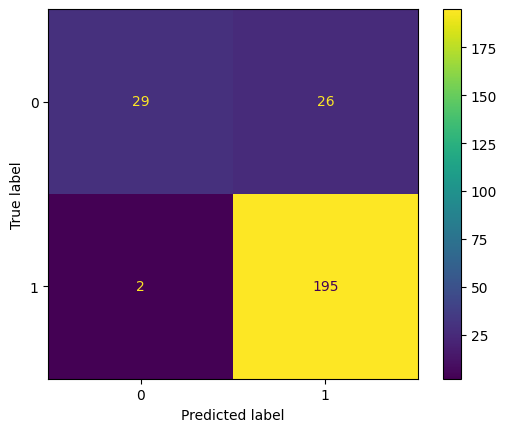

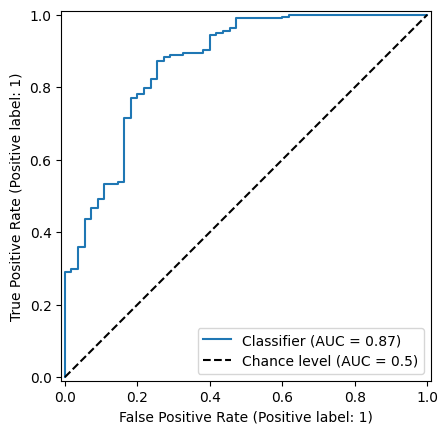

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, roc_auc_score

# Random Forests
rf_01 = RandomForestClassifier(n_estimators=350, random_state=10, min_samples_leaf=5).fit(X_train, y_train)
rf_01.seed = 42

predictions_testset_rf01 = rf_01.predict_proba(X_test)[:, 1]
predictions_testset_rf01_binary = np.where(predictions_testset_rf01 > 0.6, 1, 0)

ConfusionMatrixDisplay.from_predictions(y_test, predictions_testset_rf01_binary)


# Calculate and Print the AUC score
auc_score = roc_auc_score(y_test, predictions_testset_rf01)
print("AUC Score:", auc_score)

#plot ROC curve
RocCurveDisplay.from_predictions(y_test, predictions_testset_rf01, plot_chance_level=True)